In [1]:
import pandas as pd
import nltk     #for deleting stop words!
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import spacy
from sklearn.cluster import KMeans

from sklearn.cluster import DBSCAN
import numpy as np

In [2]:
df = pd.read_csv('dataset.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3897 entries, 0 to 3896
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  3897 non-null   object
dtypes: object(1)
memory usage: 30.6+ KB


,document
count,3897
unique,3897
top,From: melabdel@cobra.cs.unm.edu (Mohammed Elab...
freq,1


In [3]:
#deleting \n & \r
df['document'] = df['document'].str.replace(r'[\n\r]', ' ', regex=True)

# Remove all occurrences of '$' from the text column
df['document'] = df['document'].str.replace(r'\$', '', regex=True)

In [4]:
#deleting stop words

nltk.download('stopwords')

# Set of stop words
stop_words = set(stopwords.words('english'))

# Remove stop words from the text column
df['document'] = df['document'].apply(lambda x: ' '.join(word for word in x.split() if word.lower() not in stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# #replacing using stemming
# stemmer = PorterStemmer()
# # Apply stemming
# df['document'] = df['document'].apply(lambda x: ' '.join(stemmer.stem(word) for word in x.split()))


#replacing using limmitization
nlp = spacy.load('en_core_web_sm')
# Apply lemmatization
df['document'] = df['document'].apply(lambda x: ' '.join(token.lemma_ for token in nlp(x)))


In [35]:
from sentence_transformers import SentenceTransformer

#loading the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
data = df['document'].tolist()


embeddings = model.encode(data, show_progress_bar=True)

# for i, embedding in enumerate(embeddings):
#     print(f"Sentence: {data[i]}")
#     print(f"Embedding (first 5 values): {embedding[:5]}\n")

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

# ***Elbow Method***

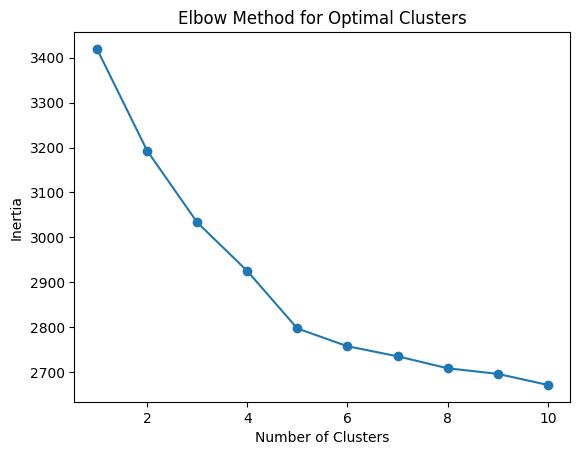

In [36]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()


## **K-means**

In [37]:

num_clusters = 5

#K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)

KMeans(n_clusters=5, random_state=42)

# **DBSCAN**

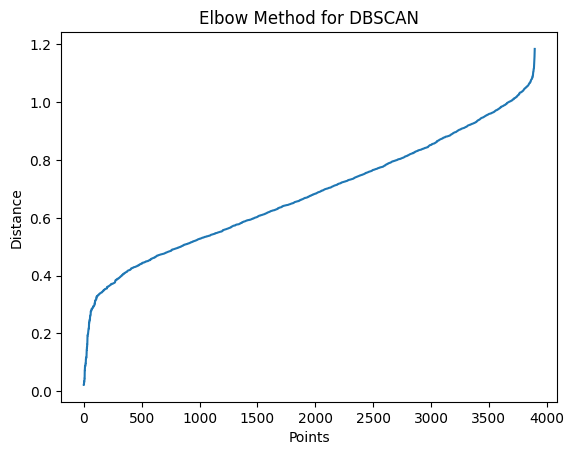

In [38]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(embeddings)
distances, indices = neighbors_fit.kneighbors(embeddings)

distances = np.sort(distances[:, 1])
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distance')
plt.title('Elbow Method for DBSCAN')
plt.show()

In [62]:

#DBscan
dbscan = DBSCAN(eps=0.36, min_samples=4, metric='euclidean')
labels_dbscan = dbscan.fit_predict(embeddings)

# **Hierarchical clustering**

In [63]:
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


#Hierarchical
linkage_matrix = linkage(embeddings, method='ward')

num_clusters = 5
labels_hier = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# #Dendogram
# plt.figure(figsize=(5, 3))
# dendrogram(linkage_matrix, labels=data, orientation='top')
# plt.title("Hierarchical Clustering Dendrogram")
# plt.xlabel("Data Points")
# plt.ylabel("Distance")
# plt.show()

# **Comparison**

In [64]:
from sklearn.metrics import silhouette_score

kmeans_silhouette = silhouette_score(embeddings, kmeans.labels_)
dbscan_silhouette = silhouette_score(embeddings, labels_dbscan)
hierarchical_silhouette = silhouette_score(embeddings, labels_hier)

print("Silhouette Scores:")
print(f"K-Means: {kmeans_silhouette}")
print(f"DBSCAN: {dbscan_silhouette}")
print(f"Hierarchical: {hierarchical_silhouette}")


Silhouette Scores:
K-Means: 0.07769274711608887
DBSCAN: -0.0948309674859047
Hierarchical: 0.08096538484096527


In [69]:
import numpy as np
print("Cluster Distribution:")

print("K-Means:", np.unique(kmeans.labels_, return_counts=True))
print("DBSCAN:", np.unique(labels_dbscan, return_counts=True))  # -1 indicates noise
print("Hierarchical:", np.unique(labels_hier, return_counts=True))


Cluster Distribution:
K-Means: (array([0, 1, 2, 3, 4], dtype=int32), array([841, 670, 896, 602, 888]))
DBSCAN: (array([-1,  0,  1,  2,  3]), array([3876,    4,    5,    5,    7]))
Hierarchical: (array([1, 2, 3, 4, 5], dtype=int32), array([ 950,  569,  298,  881, 1199]))


# **PCA**

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

In [42]:
from sklearn.cluster import KMeans

#KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(reduced_embeddings)


In [57]:
from sklearn.cluster import DBSCAN

#DBSCAN
dbscan = DBSCAN(eps=0.005, min_samples=2)
dbscan_labels = dbscan.fit_predict(reduced_embeddings)


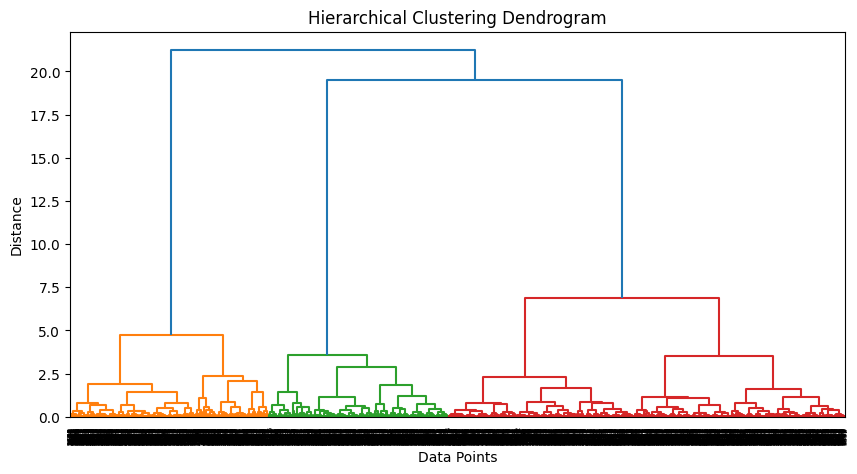

In [65]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

#Hierarchical
linkage_matrix = linkage(reduced_embeddings, method='ward')

#dendogram
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, orientation='top')
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

num_clusters = 5
hier_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

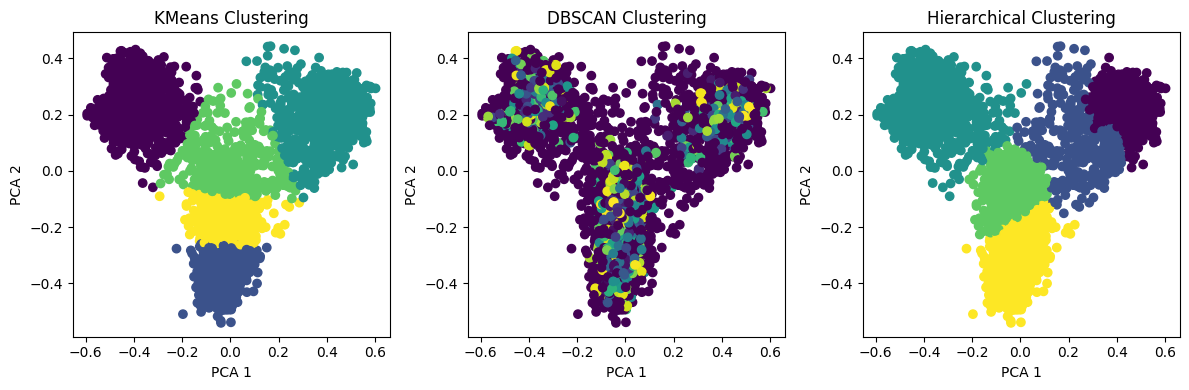

In [66]:
import matplotlib.pyplot as plt

#KMeans
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('KMeans Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

#DBSCAN
plt.subplot(1, 3, 2)
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

#Hierarchical
plt.subplot(1, 3, 3)
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=hier_labels, cmap='viridis')
plt.title('Hierarchical Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()


In [68]:
from sklearn.metrics import silhouette_score

#Silhouette Score
kmeans_score = silhouette_score(reduced_embeddings, kmeans_labels)
dbscan_score = silhouette_score(reduced_embeddings, dbscan_labels)
agg_score = silhouette_score(reduced_embeddings, hier_labels)

print(f"KMeans Silhouette Score: {kmeans_score}")
print(f"DBSCAN Silhouette Score: {dbscan_score}")
print(f"Hierarchical Clustering Silhouette Score: {agg_score}")


KMeans Silhouette Score: 0.4897468388080597
DBSCAN Silhouette Score: -0.07823939621448517
Hierarchical Clustering Silhouette Score: 0.46681392192840576


In [ ]:
from sklearn.metrics import homogeneity_score


# true_labels??

# KMeans Homogeneity
kmeans_homogeneity = homogeneity_score(reduced_embeddings, kmeans_labels)
print(f"KMeans Homogeneity Score: {kmeans_homogeneity}")

# DBSCAN Homogeneity
dbscan_homogeneity = homogeneity_score(reduced_embeddings, dbscan_labels)
print(f"DBSCAN Homogeneity Score: {dbscan_homogeneity}")

# Agglomerative Clustering Homogeneity
agg_homogeneity = homogeneity_score(reduced_embeddings, hier_labels)
print(f"Agglomerative Clustering Homogeneity Score: {agg_homogeneity}")
